In [2]:
import pandas as pd

# Carregar dataframe salvo em formato pickle
df = pd.read_pickle("ge_df.pkl")

In [3]:
# Converte a coluna 'Texto' do DataFrame em uma lista e armazena na variável preprocessed_articles, para ser usada no word2vec
preprocessed_articles = df['Texto'].tolist()

In [4]:
from gensim.models import Word2Vec

# Carrega o modelo Word2Vec para um arquivo
word2vec_model = Word2Vec.load("word2vec_model.model")

In [5]:
# Cria dois dicionários para mapear as palavras aos seus respectivos índices e vice-versa.
# Isso é feito para facilitar a conversão entre palavras e índices durante a criação de sequências
# numéricas que representam os textos. Essas sequências numéricas serão usadas como entrada para
# modelos de aprendizado de máquina, como redes neurais.
# Exemplo: 
# Suponha que o vocabulário seja ['casa', 'carro', 'jardim'], então os dicionários serão:
# word_to_index = {'casa': 1, 'carro': 2, 'jardim': 3}
# index_to_word = {1: 'casa', 2: 'carro', 3: 'jardim'}

# 'word_to_index' é um dicionário que mapeia cada palavra ao seu índice correspondente.
word_to_index = {}

# 'index_to_word' é um dicionário que mapeia cada índice à palavra correspondente.
index_to_word = {}

# Itera sobre a lista de palavras únicas obtida do modelo Word2Vec
for i, word in enumerate(word2vec_model.wv.index_to_key):
    # Atribui a palavra ao índice i + 1 no dicionário 'word_to_index'.
    # Os índices começam em 1 para reservar o índice 0 para preenchimento (padding) quando necessário.
    word_to_index[word] = i + 1
    
    # Atribui o índice i + 1 à palavra no dicionário 'index_to_word'.
    index_to_word[i + 1] = word

In [6]:
from tqdm import tqdm

# 'sequences' é uma lista que armazenará as sequências numéricas correspondentes aos artigos pré-processados.
sequences = []

# Itera sobre os artigos pré-processados.
for tokens in tqdm(preprocessed_articles):
    # 'sequence' é uma lista temporária que armazenará a sequência numérica para o artigo atual.
    sequence = []
    
    # Itera sobre os tokens (palavras) no artigo atual.
    for token in tokens:
        # Verifica se o token atual está presente no dicionário 'word_to_index'.
        if token in word_to_index:
            # Se o token estiver presente, adiciona o índice correspondente à lista 'sequence'.
            sequence.append(word_to_index[token])
    
    # Após processar todos os tokens do artigo atual, adiciona a sequência numérica completa à lista 'sequences'.
    sequences.append(sequence)

100%|██████████| 7199/7199 [00:00<00:00, 9182.42it/s] 


In [7]:
# Utiliza uma compreensão de lista para converter a sequência numérica do primeiro artigo em uma lista de palavras.
# Para cada índice 'i' na sequência numérica 'sequences[0]', obtém a palavra correspondente no dicionário 'index_to_word'.
# A compreensão de lista retorna uma lista de palavras.
word_list = [index_to_word[i] for i in sequences[0]]

# Usa o método 'join()' para combinar as palavras da lista 'word_list' em uma única string.
# As palavras são separadas por um espaço em branco.
text = " ".join(word_list)

# Imprime o texto reconstruído a partir da sequência numérica.
print(text)

poder decidir expulsar deputado federal Carlos gaguim partido Apos policia federal busca apreensoes gabinete de ele Camara legenda abrir espaco receber senadora expulsar pmdb katia abreu nota legenda informar afastamento parlamentar ja acordar filiado sigla “ parlamentar ter comunicar conclusao desfiliacao semana fato noticiar hoje executiva nacional poder solicitar imediato cancelamento filiacao quadro partido ” partido passado chegar cogitar lancar parlamentar candidato senado “ investigacao amplo apuracao eventual crime cometir consequente responsabilizacao envolvido ser puner maximo rigor lei independentemente posicao cargo ocupar ”


In [8]:
import numpy as np

# Calcula o comprimento de cada sequência em 'sequences' e armazena os resultados na lista 'sequence_lengths'
sequence_lengths = [len(seq) for seq in sequences]

# Calcula a média dos comprimentos das sequências usando a função 'mean' do numpy
mean_length = np.mean(sequence_lengths)

# Obtém o comprimento máximo das sequências usando a função 'max' do Python
max_length = max(sequence_lengths)

# Imprime a média e o comprimento máximo das sequências
print("Mean sequence length: ", mean_length)
print("Maximum sequence length: ", max_length)

Mean sequence length:  340.45117377413527
Maximum sequence length:  3835


In [9]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula o percentil 95 dos comprimentos das sequências (preserva 95% das sequências)
max_length = int(np.percentile(sequence_lengths, 95))

# Realiza o preenchimento das sequências com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [10]:
df['label'].nunique() # Retorna o número de categorias únicas (classes) presentes na coluna 'label'

2

In [11]:
import tensorflow.keras.utils as ku

# Converte rótulos para one-hot encoding
num_classes = df['label'].nunique()
labels = ku.to_categorical(df['label'], num_classes)

In [12]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [13]:
from sklearn.model_selection import train_test_split

# Divida os dados em um conjunto de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3)

# Divida o conjunto temporário em conjuntos de validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  # 0.5 * 0.3 = 0.15

In [14]:
# Treinamento da Vanilla LSTM
import tensorflow as tf
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Cria modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=len(word2vec_model.wv.key_to_index) + 1, 
                    output_dim=word2vec_model.vector_size, input_length=max_length))
model.add(LSTM(units=128))
model.add(Dense(units=len(labels[0]), activation='softmax'))

# Chamada ao Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Compila modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina modelo
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1)

Epoch 1/40
79/79 [==============================] - 26s 210ms/step - loss: 0.7029 - accuracy: 0.5434 - val_loss: 0.6755 - val_accuracy: 0.5685
Epoch 2/40
79/79 [==============================] - 13s 170ms/step - loss: 0.7260 - accuracy: 0.5257 - val_loss: 0.6861 - val_accuracy: 0.5657
Epoch 3/40
79/79 [==============================] - 14s 175ms/step - loss: 0.6806 - accuracy: 0.5489 - val_loss: 0.6722 - val_accuracy: 0.5667
Epoch 4/40
79/79 [==============================] - 13s 168ms/step - loss: 0.6667 - accuracy: 0.5406 - val_loss: 0.6576 - val_accuracy: 0.5685
Epoch 5/40
79/79 [==============================] - 12s 155ms/step - loss: 0.6559 - accuracy: 0.5551 - val_loss: 0.6507 - val_accuracy: 0.5731
Epoch 6/40
79/79 [==============================] - 13s 170ms/step - loss: 0.6635 - accuracy: 0.5549 - val_loss: 0.6598 - val_accuracy: 0.4861
Epoch 7/40
79/79 [==============================] - 13s 171ms/step - loss: 0.6555 - accuracy: 0.5455 - val_loss: 0.6527 - val_accuracy: 0.5704

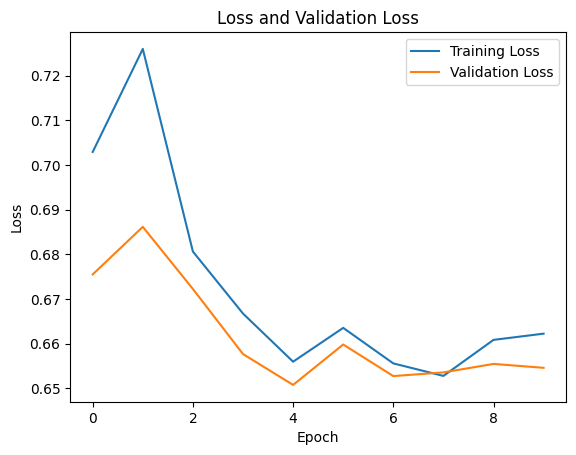

In [16]:
import matplotlib.pyplot as plt

# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Salva arquivos em discos que podemos carregar sem treinar a rede neural novamente
model.save('ge_LSTM.h5')
np.save("X_test_LSTM.npy", X_test)
np.save("y_test_LSTM.npy", y_test)

In [18]:
from tensorflow.keras.models import load_model
import numpy as np

# Carrega arquivos pertinentes ao treinamento da rede neural e X_test e y_test (usados na avaliação de resultados)
model = load_model('ge_LSTM.h5')
X_test = np.load("X_test_LSTM.npy")
y_test = np.load("y_test_LSTM.npy")

In [19]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Acurácia final:', accuracy)

Acurácia final: 0.5490740537643433


In [20]:
# Fazer as previsões do modelo para o conjunto de teste
y_pred = model.predict(X_test)

34/34 [==============================] - 2s 53ms/step


In [21]:
#Transformar as previsões de volta em rótulos
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

conf_mat

array([[542,   0],
       [487,  51]], dtype=int64)

In [22]:
import pandas as pd

# Lê o arquivo .csv
df = pd.read_pickle("ge_df.pkl")

# Total de classes
classes = df['label'].nunique()

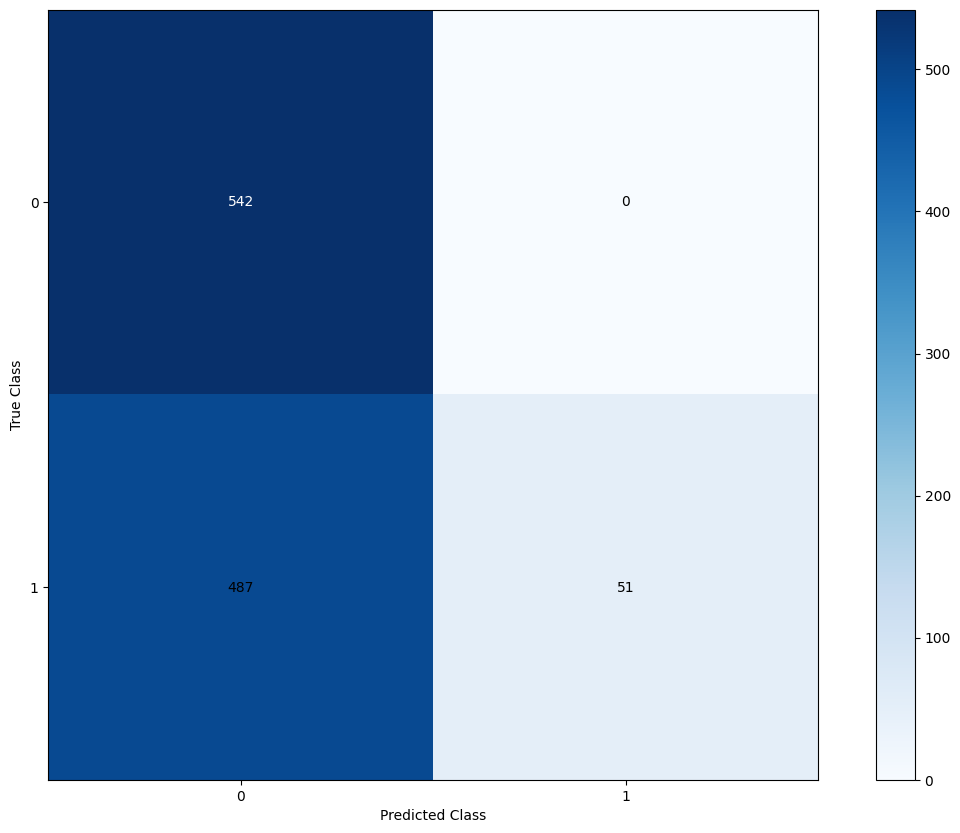

In [23]:
import matplotlib.pyplot as plt

# Define o tamanho da figura
plt.figure(figsize=(15, 10))

# Define mapa de cores
cmap = plt.cm.Blues

# Plota matriz de confusão
plt.imshow(conf_mat, cmap=cmap)
plt.colorbar()

# Adiciona rótulos a matriz
plt.xticks([int(i) for i in range(2)], [str(i) for i in range(2)])
plt.yticks([int(i) for i in range(2)], [str(i) for i in range(2)])

for i in range(classes):
    for j in range(classes):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white' if conf_mat[i, j] > len(y_true_labels)/ classes else 'black')

# Adiciona rótulos dos eixos
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Mostra o plot
plt.show()

In [24]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcula precisão, recall e f1-score para cada classe
precisions = []
recalls = []
f1_scores = []
for i in range(classes):
    precision = precision_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    recall = recall_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    f1 = f1_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
# Printa resultados
for i in range(classes):
    print(f"Class '{i}': Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")

# Calcula e printa a média dos f1-scores
f1_average = np.mean(f1_scores)
print(f"Average F1-Score: {f1_average:.4f}")

Class '0': Precision=0.5267, Recall=1.0000, F1-Score=0.6900
Class '1': Precision=1.0000, Recall=0.0948, F1-Score=0.1732
Average F1-Score: 0.4316
